In [191]:
import random
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

In [263]:
NC = np.load('/Users/govindramesh/Horizon/FINAL_IMAGES/NC.npy')
PD = np.load('/Users/govindramesh/Horizon/FINAL_IMAGES/PD.npy')

data = []

for i in range(len(NC)):
    data.append([NC[i],0])

for i in range(len(PD)):
    data.append([PD[i],1])
    
data = np.array(data)
np.random.shuffle(data)

#X = np.concatenate((NC,PD),axis = 0)
#y = np.concatenate((np.zeros(len(NC)),np.ones(len(PD))))

In [264]:
X_train = []
X_test = []

for i in range(len(data)-20): X_train.append(data[i,0])
    
for i in range(20): X_test.append(data[-(i+1),0])

X_train = np.array(X_train)
X_test = np.array(X_test)

#X_train = data[:-20,0]
#X_test = data[-20:,0]

y_train = data[:-20,1]
y_test = data[-20:,1]

y_train = to_categorical(y_train).astype(np.integer)
y_test = to_categorical(y_test).astype(np.integer)

In [274]:
sample_shape = (91, 23, 38, 1)
batch_size = 64
no_epochs = 2
learning_rate = 0.01
no_classes = 2
validation_split = 0.2
verbosity = 1

In [275]:
model = Sequential()
model.add(Conv3D(8, kernel_size=(5, 5, 5), padding = 'same', activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding = 'same'))
model.add(Conv3D(16, kernel_size=(5, 5, 5), padding = 'same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding = 'same'))
#model.add(Dropout(.5))
model.add(Flatten())
model.add(Dense(4000, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(no_classes, activation='softmax'))

In [276]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])

In [277]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=no_epochs,
                    verbose=verbosity,
                    validation_split=validation_split)

Epoch 1/2
3/3 [==============================] - 39s 13s/step - loss: 1025788.2500 - accuracy: 0.4539 - val_loss: 10264.0439 - val_accuracy: 0.5000
Epoch 2/2
3/3 [==============================] - 36s 12s/step - loss: 7388.8389 - accuracy: 0.5035 - val_loss: 468.1515 - val_accuracy: 0.5000


In [269]:
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 2280.351318359375 / Test accuracy: 0.5


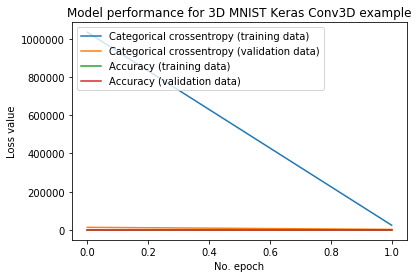

In [270]:
plt.plot(history.history['loss'], label='Categorical crossentropy (training data)')
plt.plot(history.history['val_loss'], label='Categorical crossentropy (validation data)')
plt.plot(history.history['accuracy'], label='Accuracy (training data)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Model performance for 3D MNIST Keras Conv3D example')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()